In [51]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from collections import Counter
from sklearn.metrics import classification_report

In [2]:
dataset_dir = 'CK+'

images = []
labels = []

In [3]:
for label in os.listdir(dataset_dir):
    print(label)

anger
contempt
disgust
fear
happiness
neutral
sadness
surprise


Zbiór pełny CK+ jest podzielony na 8 emocji w odróznieniu od naszego wcześniejszego okrojonego zbioru CK, gdzie było 7 emocji. Dochodzi tutaj emocja `neutral`.

In [4]:
for label in os.listdir(dataset_dir):
    label_dir = os.path.join(dataset_dir, label)
    if os.path.isdir(label_dir):

        # przechodzę przez każdy obraz w podfolderze
        for filename in os.listdir(label_dir):

            # zapisuję ścieżkę do obrazu
            img_path = os.path.join(label_dir, filename)

            # wczytuję obraz
            # ważne: jeśli nie wczytam tutaj w skali szarości, to wczytują się 3 kanały koloru (RGB)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            # jeśli obraz został odpowiednio wczytany
            if img is not None:

                # dodaję obraz oraz odpowiadającą mu etykietę do list
                images.append(img)
                labels.append(label)

In [5]:
print(len(images))
print(len(labels))

920
920


In [45]:
label_counts = Counter(labels)
for label, n in label_counts.items():
    print(f'Number of counts for {label} emotion: {n}')


Number of counts for anger emotion: 45
Number of counts for contempt emotion: 18
Number of counts for disgust emotion: 59
Number of counts for fear emotion: 25
Number of counts for happiness emotion: 69
Number of counts for neutral emotion: 593
Number of counts for sadness emotion: 28
Number of counts for surprise emotion: 83


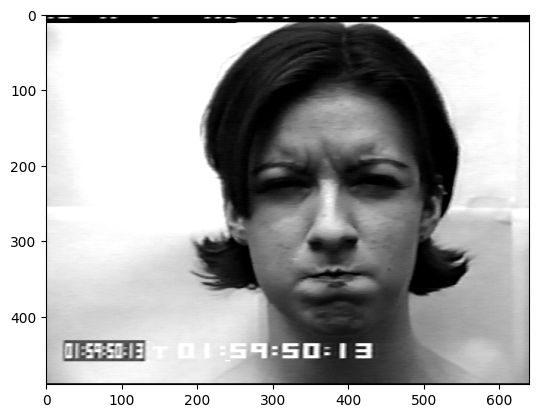

In [7]:
plt.imshow(images[0], cmap='gray')
plt.show()

In [8]:
faces = []
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

width = 200
height = 200

for image in images:
    
    face = face_cascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    try:
        x, y, w, h = face[0]  # Pobranie współrzędnych i rozmiaru pierwszej znalezionej twarzy
        cropped_image = image[y:y+h, x:x+w]  # Przycięcie zdjęcia do obszaru zawierającego twarz
        resized = cv2.resize(cropped_image, (width, height))
    
        faces.append(resized)

    except:
        continue


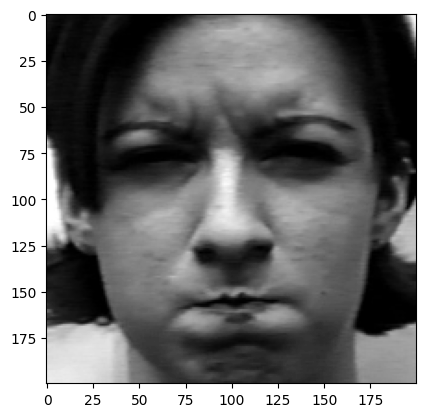

920


In [9]:
plt.imshow(faces[0], cmap='gray')
plt.show()
print(len(faces))

In [10]:
X = np.array(faces)
y = np.array(labels)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
print("Kształt X_train:", X_train.shape)
print("Kształt y_train:", y_train.shape)
print("Kształt X_test:", X_test.shape)
print("Kształt y_test:", y_test.shape)

Kształt X_train: (736, 200, 200)
Kształt y_train: (736,)
Kształt X_test: (184, 200, 200)
Kształt y_test: (184,)


In [13]:
y_test

array(['neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'disgust',
       'neutral', 'neutral', 'neutral', 'anger', 'happiness', 'surprise',
       'neutral', 'neutral', 'sadness', 'disgust', 'neutral', 'neutral',
       'anger', 'neutral', 'neutral', 'neutral', 'neutral', 'disgust',
       'neutral', 'neutral', 'neutral', 'neutral', 'surprise', 'neutral',
       'neutral', 'disgust', 'disgust', 'disgust', 'neutral', 'neutral',
       'disgust', 'neutral', 'fear', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'happiness', 'neutral', 'neutral', 'anger',
       'disgust', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'happiness', 'disgust', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'surprise',
       'neutral', 'surprise', 'neutral', 'sadness', 'neutral', 'anger',
       'neutral', 'neutral', 'happiness', 'neutral', 'fear', 'sadness',
       'neutral', 'neutral', 'neutral', 'surprise', '

In [14]:
unique = np.setdiff1d(np.unique(y_test), np.unique(y_train))
print(len(unique))

0


In [15]:
y_train_encoded = LabelEncoder().fit_transform(y_train)
y_test_encoded = LabelEncoder().fit_transform(y_test)

In [16]:
Y_train = to_categorical(y_train_encoded, 8)
Y_test = to_categorical(y_test_encoded, 8)

In [17]:
X_train = X_train.reshape(-1, width, height, 1)
X_test = X_test.reshape(-1, width, height, 1)
X_train.shape, X_test.shape

((736, 200, 200, 1), (184, 200, 200, 1))

In [18]:
# Convert from uint8 to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# Convert pixel values range from 0-255 to 0-1
X_train = X_train / 255.
X_test = X_test / 255.

In [19]:
# Split training data one more time to create partition for validation data. This should reduce overfitting and validate training
X_train, X_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=13)

In [20]:
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((588, 200, 200, 1), (148, 200, 200, 1), (588, 8), (148, 8))

In [21]:
unique_v = np.setdiff1d(np.unique(y_train), np.unique(y_valid))
print(len(unique_v))

0


# Network

In [22]:
import keras
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU

In [23]:
batch_size = 64
epochs = 20
num_classes = 8

In [24]:
emotion_model = Sequential()
emotion_model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(width, height ,1),padding='same'))
emotion_model.add(LeakyReLU(alpha=0.1))
emotion_model.add(MaxPooling2D((2, 2),padding='same'))
emotion_model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
emotion_model.add(LeakyReLU(alpha=0.1))
emotion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
emotion_model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
emotion_model.add(LeakyReLU(alpha=0.1))                  
emotion_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
emotion_model.add(Flatten())
emotion_model.add(Dense(128, activation='linear'))
emotion_model.add(LeakyReLU(alpha=0.1))                  
emotion_model.add(Dense(num_classes, activation='softmax'))

C:\Users\mikos\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\mikos\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [25]:
emotion_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

In [26]:
emotion_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 200, 200, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 200, 200, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 100, 100, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 100, 100, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 100, 100, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 50, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 50, 50, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 80000)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      10,240,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,333,832 (39.42 MB)

 Trainable params: 10,333,832 (39.42 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
emotion_train = emotion_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_valid, y_valid))


Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 622ms/step - accuracy: 0.3736 - loss: 2.1533 - val_accuracy: 0.5743 - val_loss: 1.6022
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 601ms/step - accuracy: 0.6546 - loss: 1.3060 - val_accuracy: 0.5743 - val_loss: 1.5264
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 625ms/step - accuracy: 0.6812 - loss: 1.1696 - val_accuracy: 0.5811 - val_loss: 1.4634
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 668ms/step - accuracy: 0.6436 - loss: 1.1535 - val_accuracy: 0.6216 - val_loss: 1.4748
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 603ms/step - accuracy: 0.7031 - loss: 1.0191 - val_accuracy: 0.7162 - val_loss: 1.2124
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 579ms/step - accuracy: 0.8512 - loss: 0.5480 - val_accuracy: 0.6959 - val_loss: 0.9722
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 639ms/step - accuracy: 0.8304 - loss: 0.5152 - val_accuracy: 0.7365 - val_loss: 0.8928
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 658ms/step - accuracy: 0.9035 - loss: 0.3181 - val_accuracy: 0.

In [28]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

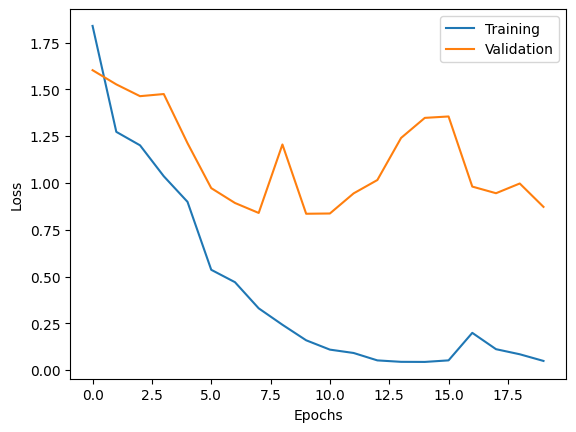

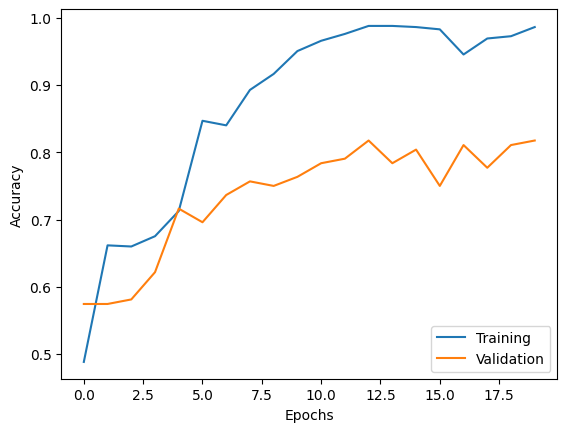

In [29]:
plot_history(emotion_train)

In [30]:
# pixels 200x200 - accuracy = 99, validation = 82%'

In [31]:
predicted_classes = emotion_model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


In [32]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 4, 7, 5, 5, 0, 2, 5, 5, 0, 5, 5, 5,
       5, 2, 5, 5, 5, 5, 7, 5, 5, 2, 2, 2, 5, 5, 2, 5, 3, 5, 5, 0, 5, 5,
       4, 5, 5, 0, 2, 5, 5, 5, 5, 5, 5, 5, 5, 4, 2, 5, 5, 5, 5, 5, 5, 7,
       5, 7, 5, 5, 0, 0, 5, 5, 4, 5, 3, 2, 5, 5, 5, 7, 5, 7, 7, 7, 6, 5,
       5, 3, 5, 5, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 5, 0, 5, 4,
       4, 4, 4, 5, 7, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5,
       2, 4, 5, 5, 5, 1, 5, 5, 0, 7, 7, 5, 5, 5, 7, 0, 5, 5, 5, 5, 0, 7,
       5, 5, 0, 5, 7, 5, 5, 7, 0, 2, 5, 5, 2, 5, 0, 5, 0, 5, 5, 5, 0, 5,
       5, 5, 5, 5, 4, 7, 5, 5], dtype=int64)

In [33]:
predicted_classes.shape, Y_test.shape

((184,), (184, 8))

Found 159 correct labels


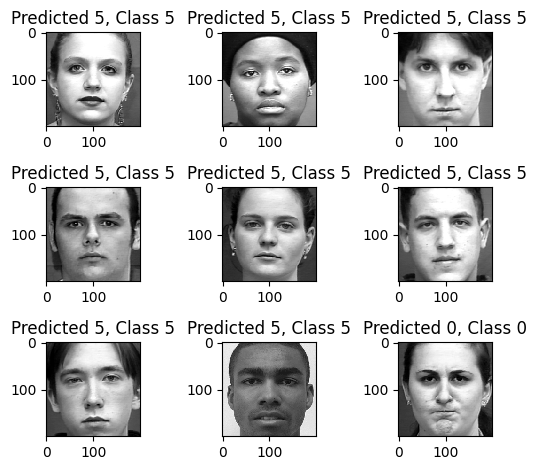

In [34]:
correct = np.where(predicted_classes==y_test_encoded)[0]
print(f"Found {len(correct)} correct labels")
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(width, height), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test_encoded[correct]))
    plt.tight_layout()

Found 25 incorrect labels


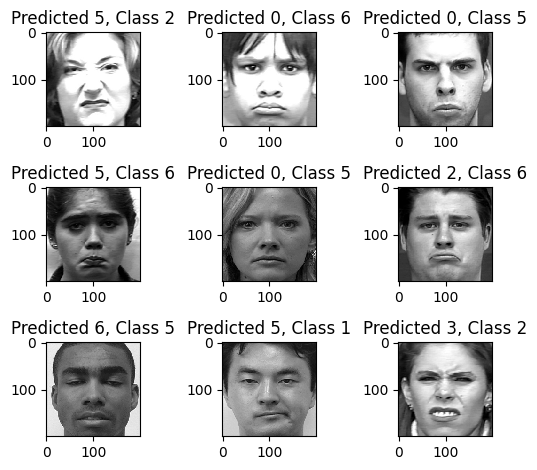

In [35]:
incorrect = np.where(predicted_classes!=y_test_encoded)[0]
print(f"Found {len(incorrect)} incorrect labels")
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(width, height), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test_encoded[incorrect]))
    plt.tight_layout()

In [36]:
label_encoder = LabelEncoder()
label_encoder.fit(y_test)

for word, encoded_label in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{word}: {encoded_label}")

anger: 0
contempt: 1
disgust: 2
fear: 3
happiness: 4
neutral: 5
sadness: 6
surprise: 7


In [60]:
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y_test_encoded, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.38      0.86      0.52         7
     Class 1       0.00      0.00      0.00         3
     Class 2       0.92      0.65      0.76        17
     Class 3       0.80      1.00      0.89         4
     Class 4       0.91      1.00      0.95        10
     Class 5       0.92      0.93      0.93       119
     Class 6       0.00      0.00      0.00         6
     Class 7       1.00      0.94      0.97        18

    accuracy                           0.86       184
   macro avg       0.61      0.67      0.63       184
weighted avg       0.86      0.86      0.85       184

